In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json

## Loading results

In [7]:
rca = pd.read_csv('../../data/results/rca.csv')
meta = pd.read_csv('../../data/psychNorms/psychNorms_metadata.csv', index_col='norm')

print(f"# Norms: {len(meta.index.unique())}")
print(f"# Norm categories: {len(meta['category'].unique())}")

# Adding norm category
rca['norm_category'] = (
    rca['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)
rca

# Norms: 292
# Norm categories: 27


,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,28012,7003,300,0.522118,0.008398,2.715453,0.072527,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,19285,4822,300,0.500425,0.009710,0.156666,0.004775,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,28636,7159,300,0.537265,0.009814,0.361345,0.007803,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,29316,7330,300,0.545643,0.008416,0.446042,0.009075,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,31876,7969,300,0.523700,0.008448,0.400166,0.009345,pass,frequency
...,...,...,...,...,...,...,...,...,...,...,...,...
7295,THINGS,behavior,familiarity_vanarsdall,376,95,49,0.091050,0.077868,3216.050320,580.598768,pass,familiarity
7296,THINGS,behavior,imageability_vanarsdall,376,95,49,0.074112,0.090266,1317.411401,292.505564,pass,imageability
7297,THINGS,behavior,familiarity_fear,173,44,49,0.151637,0.158767,0.782185,0.220500,pass,familiarity
7298,THINGS,behavior,aoa_fear,173,44,49,0.015012,0.129597,0.514519,0.043528,pass,age of acquisition


In [8]:
rca.query('embed_type == "brain"').sort_values(by='r2_mean', ascending=True)

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
6452,EEG_speech,brain,Nmeanings_Wordsmyth,48,13,130,-4.064703e+28,8.129407e+28,0.025339,0.008085,pass,semantic diversity
4116,fMRI_text_hyper_align,brain,Nmeanings_Wordsmyth,27,7,1000,-2.457870e+28,4.915739e+28,0.021883,0.021342,pass,semantic diversity
5469,fMRI_speech_hyper_align,brain,tabooness_janschewitz,13,4,6,-5.531746e+02,9.345201e+02,0.259429,0.460097,pass,social/moral
6321,microarray,brain,neutral_zupan,11,3,15,-4.653172e+02,9.279423e+02,2.090723,1.099283,pass,valence
6319,microarray,brain,happy_zupan,11,3,15,-8.283783e+01,9.914999e+01,7.904190,5.724221,pass,emotion
...,...,...,...,...,...,...,...,...,...,...,...,...
6651,EEG_speech,brain,aoa_juhasz,5,2,130,NaN,NaN,NaN,NaN,too few observations,age of acquisition
6652,EEG_speech,brain,transparency_juhasz,5,2,130,NaN,NaN,NaN,NaN,too few observations,iconicity/transparency
6653,EEG_speech,brain,lexeme_dominance,5,2,130,NaN,NaN,NaN,NaN,too few observations,iconicity/transparency
6654,EEG_speech,brain,imageability_juhasz,5,2,130,NaN,NaN,NaN,NaN,too few observations,imageability


In [9]:
# Stats reported in the paper
def mean_r2(embed, norm_category):
    mean_r2 = rca.query(f"embed == '{embed}' & norm_category == '{norm_category}'")['r2_mean'].mean()
    print(f'{embed} {norm_category} mean r2: {mean_r2.round(2)}')

# Mean r2s
mean_r2('CBOW_GoogleNews', 'part of speech')
mean_r2('CBOW_GoogleNews', 'animacy')
mean_r2('CBOW_GoogleNews', 'concreteness')

CBOW_GoogleNews part of speech mean r2: 0.66
CBOW_GoogleNews animacy mean r2: 0.71
CBOW_GoogleNews concreteness mean r2: 0.68


In [10]:
with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
rca['embed_type'] = rca['embed'].map(embed_to_type)
rca

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,CBOW_GoogleNews,text,Freq_HAL,28012,7003,300,0.522118,0.008398,2.715453,0.072527,pass,frequency
1,CBOW_GoogleNews,text,Freq_KF,19285,4822,300,0.500425,0.009710,0.156666,0.004775,pass,frequency
2,CBOW_GoogleNews,text,Freq_SUBTLEXUS,28636,7159,300,0.537265,0.009814,0.361345,0.007803,pass,frequency
3,CBOW_GoogleNews,text,Freq_SUBTLEXUK,29316,7330,300,0.545643,0.008416,0.446042,0.009075,pass,frequency
4,CBOW_GoogleNews,text,Freq_Blog,31876,7969,300,0.523700,0.008448,0.400166,0.009345,pass,frequency
...,...,...,...,...,...,...,...,...,...,...,...,...
7295,THINGS,behavior,familiarity_vanarsdall,376,95,49,0.091050,0.077868,3216.050320,580.598768,pass,familiarity
7296,THINGS,behavior,imageability_vanarsdall,376,95,49,0.074112,0.090266,1317.411401,292.505564,pass,imageability
7297,THINGS,behavior,familiarity_fear,173,44,49,0.151637,0.158767,0.782185,0.220500,pass,familiarity
7298,THINGS,behavior,aoa_fear,173,44,49,0.015012,0.129597,0.514519,0.043528,pass,age of acquisition


In [11]:
# Taking the embedding with the highest mean r2 from each embed_type
top_embeds = (
    rca[['embed', 'embed_type', 'r2_mean']]
    .groupby(['embed', 'embed_type'], as_index=False)
    .mean('r2_mean').set_index('embed')
    .groupby('embed_type').idxmax()['r2_mean']
)    

top_embeds

embed_type
behavior      PPMI_SVD_SWOW
brain              EEG_text
text        CBOW_GoogleNews
Name: r2_mean, dtype: object

In [12]:
# Ordering norms by top behavior model mean r2
top_behav= top_embeds['behavior']
norm_order = (
    rca[rca['embed'] == top_behav][['norm_category', 'r2_mean']]
    .groupby('norm_category').mean().sort_values(by='r2_mean')
    .index
)
rca['norm_category'] = pd.Categorical(rca['norm_category'], norm_order)
rca = rca.sort_values(by='norm_category').reset_index(drop=True)
rca

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
0,PPMI_SVD_SWOW,behavior,rt_ley,77,20,300,-0.250496,0.233934,0.011922,0.006478,pass,semantic decision
1,SGSoftMaxOutput_SWOW,behavior,rt_chen,260,66,300,0.031961,0.097916,0.017835,0.002891,pass,semantic decision
2,fastText_CommonCrawl,text,rt_khanna,1042,261,300,-0.013719,0.033896,0.027247,0.002696,pass,semantic decision
3,PPMI_SVD_SouthFlorida,behavior,accuracy_chen,148,37,300,-0.023005,0.033950,0.017189,0.004302,pass,semantic decision
4,morphoNLM,text,rt_ley,116,29,50,0.069870,0.095621,0.014139,0.002108,pass,semantic decision
...,...,...,...,...,...,...,...,...,...,...,...,...
7295,fastText_CommonCrawl,text,valence_imbault,1827,457,300,0.550388,0.042677,0.660106,0.046814,pass,valence
7296,GloVe_CommonCrawl,text,valence_hollis,829,208,300,0.755092,0.072602,0.004605,0.000343,pass,valence
7297,GloVe_Twitter,text,Pleasant_Binder,425,107,200,0.369763,0.048320,1.382831,0.065365,pass,valence
7298,GloVe_CommonCrawl,text,pleasantness_brown,505,127,300,0.643119,0.048432,0.607855,0.041162,pass,valence


In [13]:
# rca mean
rca_mean = (
    rca[['norm_category', 'embed', 'r2_mean']]
    .groupby(['norm_category', 'embed'], as_index=False).mean()
)
# rca_mean['norm_category'] = rca_mean['norm_category'].str.title()
rca_mean

,norm_category,embed,r2_mean
0,semantic decision,CBOW_GoogleNews,0.133803
1,semantic decision,EEG_speech,-0.152543
2,semantic decision,EEG_text,-0.217820
3,semantic decision,GloVe_CommonCrawl,-0.321994
4,semantic decision,GloVe_Twitter,-0.321704
...,...,...,...
670,valence,fastText_Wiki_News,0.606192
671,valence,microarray,-31.070666
672,valence,morphoNLM,0.290949
673,valence,norms_sensorimotor,0.075905


## Scatter plot

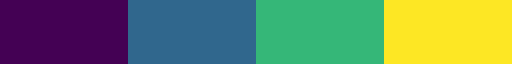

In [14]:
plt.get_cmap('viridis', 4)

In [15]:
# Colors 
cmap = plt.get_cmap('viridis', 4)
embed_type_to_color = {
    'brain': cmap(1),
    'behavior': cmap(0),
    'text': cmap(2)
}
{key: mcolors.to_hex(value) for key, value in embed_type_to_color.items()}

{'brain': '#31688e', 'behavior': '#440154', 'text': '#35b779'}

**Top embeddings**

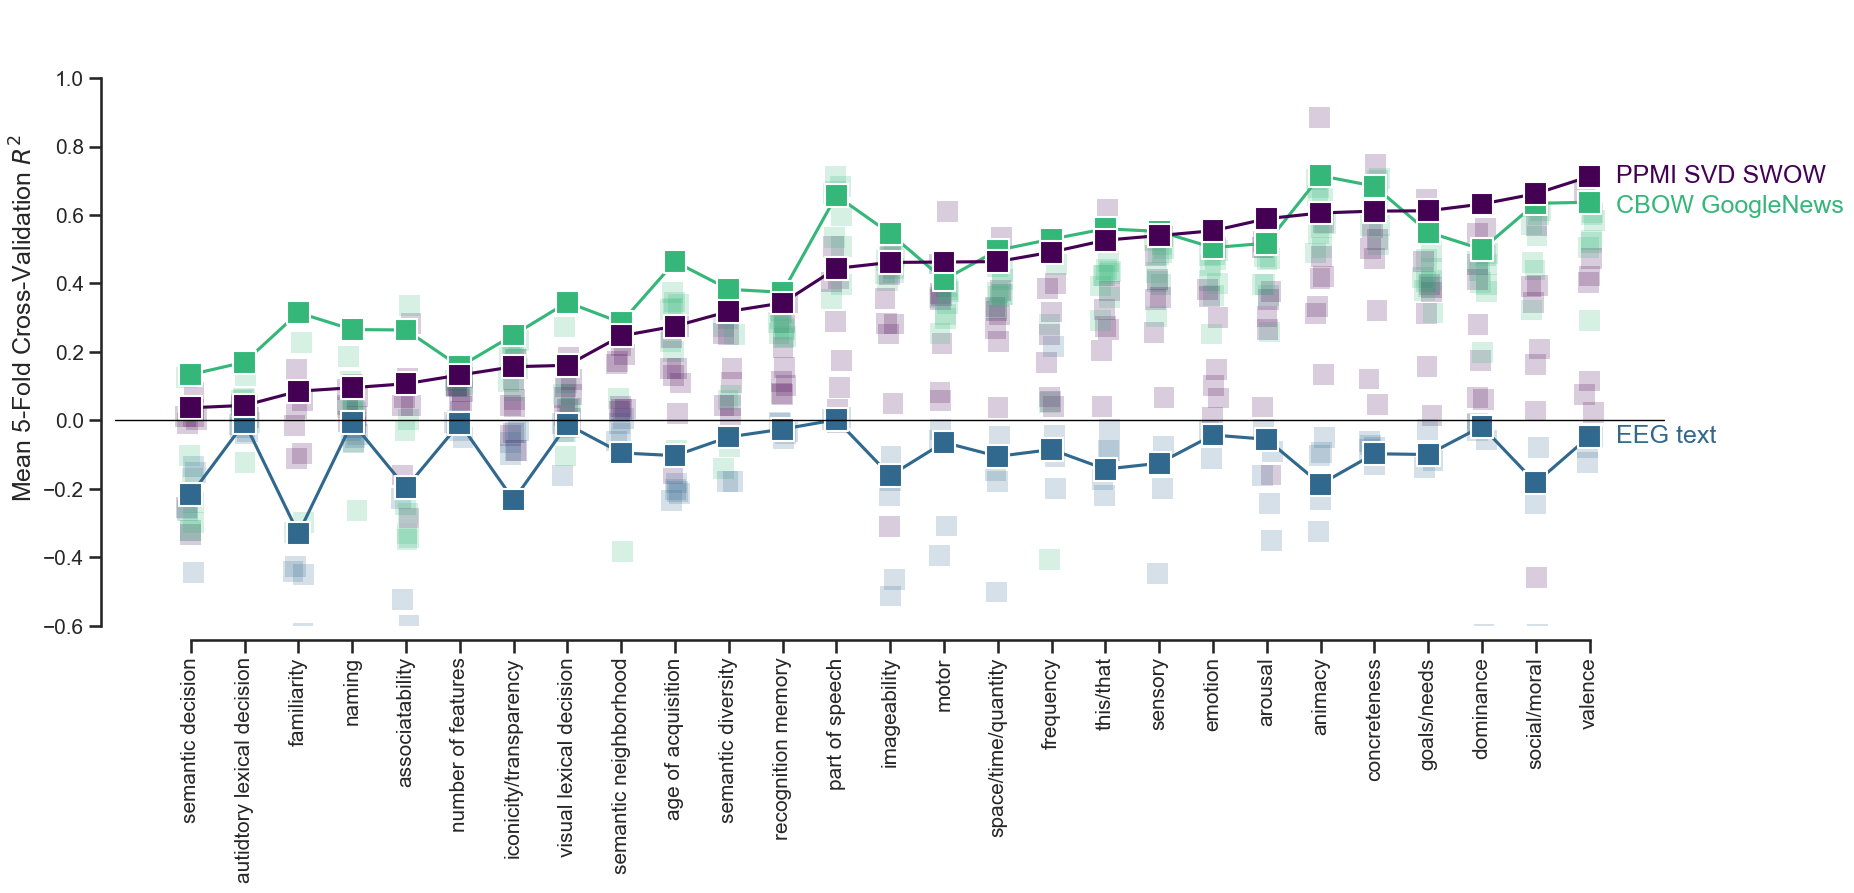

In [16]:
sns.set(context='talk', style='white')
fig, ax = plt.subplots(figsize=(20, 8))

embed_to_color = {embed: embed_type_to_color[embed_to_type[embed]] for embed in embed_to_type.keys()}

sns.stripplot(
    rca_mean.query('embed not in @top_embeds'),
    x='norm_category', y='r2_mean', hue='embed', 
    s=15, marker='s', palette=embed_to_color, alpha=.2, 
    zorder=0, ax=ax
)

sns.lineplot(
    rca_mean.query('embed in @top_embeds'),
    x='norm_category', y='r2_mean', hue='embed',
    palette=embed_to_color, zorder=1, ax=ax
)

# Square markers
sns.scatterplot(
    rca_mean.query('embed in @top_embeds'), marker='s',
    x='norm_category', y='r2_mean', hue='embed',
    s=270, palette=embed_to_color, edgecolor='white', linewidth=1.5,
    zorder=2, ax=ax
)

ax.legend_.remove()

# Labelling top embeddings on the right side in line with their right hand points
occ_ys = []
for embed in top_embeds:
    x = 26.5
    y = rca_mean.query('embed == @embed')['r2_mean'].iloc[-1]
    if occ_ys:
        while min([abs(y - occ_y) for occ_y in occ_ys]) < 0.08:
            np.random.seed(42)
            y += np.random.uniform(-0.05, 0.05)
    occ_ys.append(y)
    ax.text(x, y, embed.replace('_', ' '), ha='left', va='center', color=embed_to_color[embed], fontsize=18)

# Formatting axes
ax.set(
    ylim=(-.6, 1.2), xlabel='', ylabel='Mean 5-Fold Cross-Validation $R^2$',
    yticks=np.arange(-.6, 1.2, .2)
)
ax.axhline(0, color='black', lw=1)
ax.tick_params(axis='x', rotation=90, which='both', bottom=True, top=False, labelbottom=True, labelsize=15)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=15)

sns.despine(offset=10, trim=True)
plt.savefig('../../figures/rca.png', dpi=300, bbox_inches='tight')

## Heatmap

In [17]:
norm_order

Index(['semantic decision', 'autidtory lexical decision', 'familiarity',
       'naming', 'associatability', 'number of features',
       'iconicity/transparency', 'visual lexical decision',
       'semantic neighborhood', 'age of acquisition', 'semantic diversity',
       'recognition memory', 'part of speech', 'imageability', 'motor',
       'space/time/quantity', 'frequency', 'this/that', 'sensory', 'emotion',
       'arousal', 'animacy', 'concreteness', 'goals/needs', 'dominance',
       'social/moral', 'valence'],
      dtype='object', name='norm_category')

In [18]:
# Pivots rca_mean to a matrix for each embed type
rca_mean['embed_type'] = rca_mean['embed'].map(embed_to_type)

rca_mean_pivs = {}
embed_types = ['text', 'brain', 'behavior']
for embed_type in embed_types:
    rca_mean_piv = rca_mean.query('embed_type == @embed_type').pivot(index='embed', columns='norm_category', values='r2_mean')
    
    # Sorts index by grand mean of embeds
    embed_order = rca_mean_piv.mean(axis=1).sort_values(ascending=False).index
    rca_mean_pivs[embed_type] = rca_mean_piv[norm_order].loc[embed_order]

rca_mean.query('embed_type == "text"').pivot(index='embed', columns='norm_category', values='r2_mean')

norm_category,semantic decision,autidtory lexical decision,familiarity,naming,associatability,number of features,iconicity/transparency,visual lexical decision,semantic neighborhood,age of acquisition,...,this/that,sensory,emotion,arousal,animacy,concreteness,goals/needs,dominance,social/moral,valence
embed,,,,,,,,,,,,,,,,,,,,,
CBOW_GoogleNews,0.133803,0.169851,0.314492,0.265076,0.263870,0.156893,0.249431,0.344795,0.285272,0.463624,...,0.559614,0.551909,0.504586,0.517422,0.714660,0.684292,0.549853,0.499618,0.634021,0.637105
GloVe_CommonCrawl,-0.321994,0.060834,-2.423031,0.026743,-0.347638,0.117200,0.179149,-0.019387,-3.905170,0.372387,...,0.433699,0.513972,0.482752,0.504061,0.656998,0.648367,0.470131,0.488105,0.629154,0.635762
GloVe_Twitter,-0.321704,-0.007475,-0.985058,-0.060822,-0.246350,0.120785,0.152092,0.109403,0.064789,0.228886,...,0.422850,0.397215,0.365078,0.396123,0.563574,0.569578,0.418339,0.376785,0.538469,0.519679
GloVe_Wikipedia,-0.169004,0.018954,-0.327056,0.021734,0.003180,0.100848,0.113455,-0.032136,-161.383038,0.338109,...,0.422045,0.405293,0.407635,0.364833,0.488700,0.569566,0.405465,0.396090,0.438922,0.526916
LexVec_CommonCrawl,-0.240953,0.057799,-1.087410,0.036564,-0.331782,0.125967,0.188096,0.034143,-9.961921,0.201506,...,0.464478,0.490934,0.468142,0.477088,0.680603,0.642570,0.493571,0.437681,0.611563,0.600106
fastTextSub_OpenSub,-0.887575,-0.124040,-1.676335,-0.264466,-0.977297,0.105162,0.232124,-0.726236,-0.903566,-0.087511,...,0.392338,0.502788,0.453071,0.472462,0.658202,0.705378,0.408940,0.464486,0.602074,0.582815
fastText_CommonCrawl,-0.298236,0.026812,-4.353987,0.048533,-0.270948,0.141140,0.207182,-0.104396,-0.937036,0.324197,...,0.441698,0.524322,0.495030,0.513843,0.703137,0.700708,0.391004,0.481453,0.624886,0.630307
fastText_Wiki_News,-0.257160,0.044994,-3.177199,0.113890,-0.029628,0.140820,0.183411,0.035554,-0.383372,0.327800,...,0.358716,0.483069,0.481732,0.469907,0.574015,0.677291,0.379299,0.455525,0.572273,0.606192
morphoNLM,0.124779,0.130034,0.227899,0.186477,0.335013,0.099716,0.086333,0.272375,0.268752,0.345568,...,0.291204,0.302201,0.251968,0.257993,0.504643,0.514664,0.313571,0.198788,0.322299,0.290949


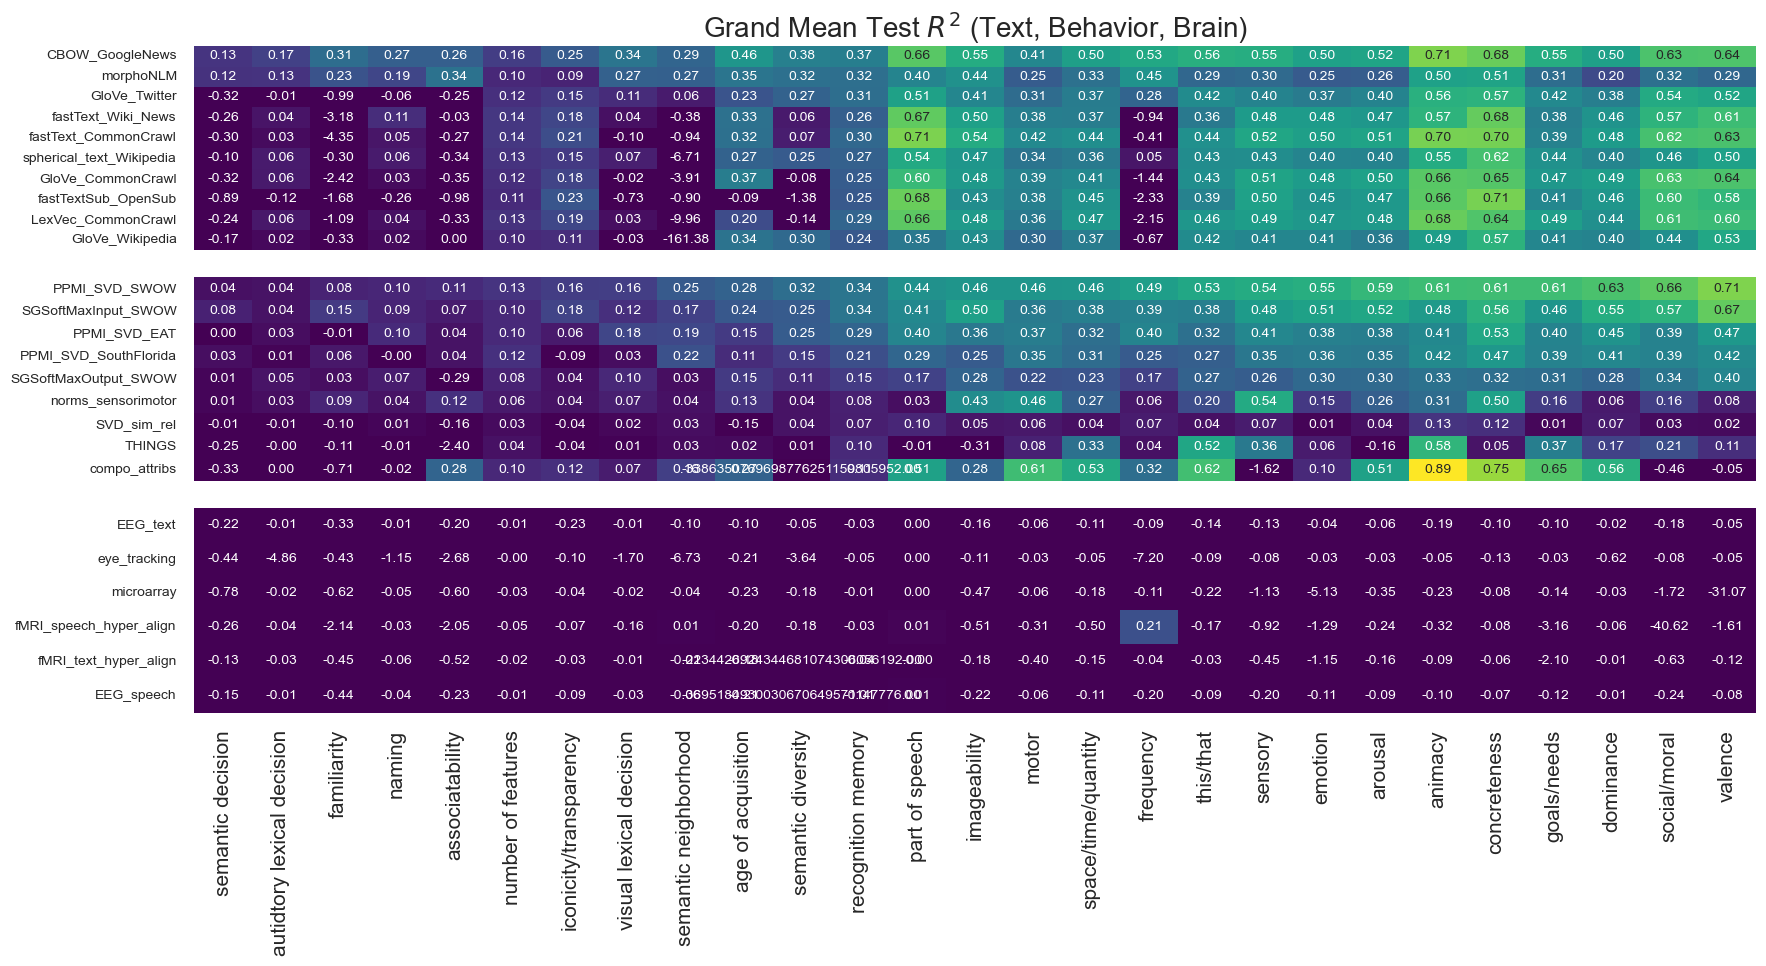

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(18, 10))

for i, embed_type in enumerate(['text', 'behavior', 'brain']):
    sns.heatmap(
        rca_mean_pivs[embed_type], cmap='viridis', ax=axs[i], vmin=0, vmax=rca_mean['r2_mean'].max(),
        annot=True, fmt='.2f', annot_kws={'fontsize': 10}, cbar=False
    )
    axs[i].set(xlabel='', ylabel='', xticklabels=[])
    
    # Ensure y-axis labels match the number of ticks
    axs[i].set_yticks(pd.Series(range(len(rca_mean_pivs[embed_type].index))) + .5)
    axs[i].set_yticklabels(rca_mean_pivs[embed_type].index, fontsize=10)
    
# Adding xticklabels to last plot
axs[-1].set_xticklabels(norm_order, rotation=90, fontsize=15)

# Sets figure title
axs[0].set_title('Grand Mean Test $R^2$ (Text, Behavior, Brain)', fontsize=20)
    
fig.tight_layout()
plt.savefig('../../figures/rca_heatmap.png', dpi=300, bbox_inches='tight')

In [20]:
rca_mean.sort_values(by='r2_mean', ascending=True)

,norm_category,embed,r2_mean,embed_type
251,semantic diversity,EEG_speech,-3.695185e+27,brain
264,semantic diversity,compo_attribs,-3.386351e+27,behavior
267,semantic diversity,fMRI_text_hyper_align,-2.234427e+27,brain
205,semantic neighborhood,GloVe_Wikipedia,-1.613830e+02,text
641,social/moral,fMRI_speech_hyper_align,-4.062348e+01,brain
...,...,...,...,...
319,part of speech,fastText_CommonCrawl,7.115699e-01,text
658,valence,PPMI_SVD_SWOW,7.125955e-01,behavior
525,animacy,CBOW_GoogleNews,7.146605e-01,text
564,concreteness,compo_attribs,7.485773e-01,behavior


In [21]:
rca.sort_values(by='r2_mean', ascending=True)

,embed,embed_type,norm,train_n,test_n,p,r2_mean,r2_sd,mse_mean,mse_sd,check,norm_category
1957,EEG_speech,brain,Nmeanings_Wordsmyth,48,13,130,-4.064703e+28,8.129407e+28,0.025339,0.008085,pass,semantic diversity
2173,compo_attribs,behavior,Nmeanings_Wordsmyth,26,7,62,-3.724986e+28,4.576956e+28,0.010190,0.005912,pass,semantic diversity
2078,fMRI_text_hyper_align,brain,Nmeanings_Wordsmyth,27,7,1000,-2.457870e+28,4.915739e+28,0.021883,0.021342,pass,semantic diversity
1423,GloVe_Wikipedia,text,Sem_N,26030,6508,300,-1.129666e+03,2.238305e+03,4.131099,2.596383,pass,semantic neighborhood
6740,fMRI_speech_hyper_align,brain,tabooness_janschewitz,13,4,6,-5.531746e+02,9.345201e+02,0.259429,0.460097,pass,social/moral
...,...,...,...,...,...,...,...,...,...,...,...,...
6949,compo_attribs,behavior,Unpleasant_Binder,427,107,62,NaN,NaN,NaN,NaN,associated_embed,valence
6951,compo_attribs,behavior,Pleasant_Binder,427,107,62,NaN,NaN,NaN,NaN,associated_embed,valence
6958,THINGS,behavior,valence_zupan,0,0,49,NaN,NaN,NaN,NaN,too few observations,valence
6961,THINGS,behavior,neutral_zupan,0,0,49,NaN,NaN,NaN,NaN,too few observations,valence
